In [3]:
import holopy as hp
from holopy.scattering import Scatterer, Sphere, calc_holo
from holopy.scattering.scatterer import Indicators
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import json
from pylorenzmie.theory import coordinates, LMHologram
from pylorenzmie.analysis.Feature import Feature
from scipy.interpolate import interp2d

In [4]:
#Instrument parameters:
wv = 0.447
mag = 0.120
n_m = 1.34 #assume water

a_p = 0.5 #um
n_p = 1.6

Tracer particle with $d_p = 1 \mu m, n_p = 1.6$, dispersed in water

In [5]:
def bound_spheres(a_1, n_1, a_2, n_2, z_p):
    #generates holograms with a single coating and double coating 
    detector = hp.detector_grid(200, mag)
    inner_sphere = Sphere(r = a_p, center = (0, 0, 0))
    center = (mag*100, mag*100, z_p)
    
    r_sum1 = a_1 + a_p
    r_sum2 = r_sum1 + a_2

    binding1 = Sphere(r = r_sum1, center = (0, 0, 0))
    binding2 = Sphere(r = r_sum2, center = (0, 0, 0))
    
    def coating1(point):
        return(np.logical_and(binding1.contains(point),
           np.logical_not(inner_sphere.contains(point))))
    
    def coating2(point):
        return(np.logical_and(binding2.contains(point),
           np.logical_not(binding1.contains(point))))


    indicators_single = Indicators([inner_sphere.contains, coating1],
                        [[-r_sum1, r_sum1], [-r_sum1, r_sum1], [-r_sum1, r_sum1]])
    
    
    indicators_double = Indicators([inner_sphere.contains, coating1, coating2],
                        [[-r_sum2, r_sum2], [-r_sum2, r_sum2], [-r_sum2, r_sum2]])

    single_scatterer = Scatterer(indicators_single,
                     (n_p, n_1), center)
    double_scatterer = Scatterer(indicators_double,
                     (n_p, n_1, n_2), center)
    
    single_holo = np.squeeze(calc_holo(detector, single_scatterer, medium_index=n_m, illum_wavelen=wv, illum_polarization=(1, 0)).data)
    double_holo = np.squeeze(calc_holo(detector, double_scatterer, medium_index=n_m, illum_wavelen=wv, illum_polarization=(1, 0)).data)
    return single_holo, double_holo

In [8]:
z_p = 50 #low end of xSight detection range [um]
a_c = 0.01 #10 nm for each coating

n_c_range = [1.4, 1.7] #possible molecular refractive indices

num_to_sample = 100

samples = {'z_p': z_p, 'a_p': a_p, 'n_p': n_p, 'a_c': a_c, 'n_1': [], 'n_2': [], 'data_single': [], 'data_double': []}

for i in range(num_to_sample):
    n_1 = np.random.uniform(low=n_c_range[0], high=n_c_range[1])
    n_2 = np.random.uniform(low=n_c_range[0], high=n_c_range[1])
    singlecoat_data, doublecoat_data = bound_spheres(a_c, n_1, a_c, n_2, z_p)
    samples['n_1'].append(n_1)
    samples['n_2'].append(n_2)
    samples['data_single'].append(singlecoat_data.tolist())
    samples['data_double'].append(doublecoat_data.tolist())
    print(i, ' completed', end='\r')

Set up pylorenzmie fitting pipeline (initialize $a_p$ and $n_p$ as the inner particle's parameters)

In [9]:
feature = Feature(model=LMHologram())
shape = [200, 200]
feature.model.coordinates = coordinates(shape, dtype=np.float32)
ins = feature.model.instrument
ins.wavelength = wv
ins.magnification = mag
ins.n_m = n_m

p = feature.model.particle
p.r_p = [shape[0]//2, shape[1]//2, z_p/mag]
p.a_p = a_p
p.n_p = n_p

feature.optimizer.mask.settings['distribution'] = 'fast'
feature.optimizer.mask.settings['percentpix'] = .1
feature.model.coordinates = coordinates(shape, dtype=np.float32)
feature.model.double_precision = False

In [10]:
#parameters that pylorenzmie will fit to
samples['a_p_1*'] = [] #single coating
samples ['n_p_1*'] = []

samples['a_p_2*'] = [] #double coating
samples ['n_p_2*'] = []


for n in range(len(samples['data_single'])):
    p = feature.model.particle
    
    #fit 1:  single coating
    p.r_p = [shape[0]//2, shape[1]//2, z_p/mag]
    p.a_p = a_p
    p.n_p = n_p
    feature.data = np.array(samples['data_single'][n])
    result = feature.optimize(method='lm', verbose=False)
    print(result)
    a_fit = feature.model.particle.a_p
    n_fit = feature.model.particle.n_p
    
    samples['a_p_1*'].append(a_fit)
    samples['n_p_1*'].append(n_fit)
    
    #fit 2: double coating
    p.r_p = [shape[0]//2, shape[1]//2, z_p/mag]
    p.a_p = a_p
    p.n_p = n_p
    feature.data = np.array(samples['data_double'][n])
    result = feature.optimize(method='lm', verbose=False)
    print(result)
    a_fit = feature.model.particle.a_p
    n_fit = feature.model.particle.n_p
    
    samples['a_p_2*'].append(a_fit)
    samples['n_p_2*'].append(n_fit)

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0005488200131716506
nfev: 19
x_p: 99.95068 (init: 100.00000)
y_p: 99.95207 (init: 100.00000)
z_p: 416.49479 (init: 416.66667)
a_p: 0.51284 (init: 0.50000)
n_p: 1.59503 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.12000 (init: 0.12000) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0005991765392175355
nfev: 19
x_p: 99.81593 (init: 100.00000)
y_p: 99.81701 (init: 100.00000)
z_p: 416.62710 (init: 416.66667)
a_p: 0.52392 (init: 0.50000)
n_p: 1.59590 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.1200

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0006212436565793281
nfev: 19
x_p: 99.94269 (init: 100.00000)
y_p: 99.94371 (init: 100.00000)
z_p: 416.46677 (init: 416.66667)
a_p: 0.50489 (init: 0.50000)
n_p: 1.59440 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.12000 (init: 0.12000) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0006166220400912702
nfev: 25
x_p: 99.79440 (init: 100.00000)
y_p: 99.79845 (init: 100.00000)
z_p: 416.57295 (init: 416.66667)
a_p: 0.50917 (init: 0.50000)
n_p: 1.59392 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.1200

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0006209442499669841
nfev: 19
x_p: 99.94283 (init: 100.00000)
y_p: 99.94351 (init: 100.00000)
z_p: 416.45267 (init: 416.66667)
a_p: 0.50274 (init: 0.50000)
n_p: 1.59445 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.12000 (init: 0.12000) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0006680776504928749
nfev: 19
x_p: 99.79778 (init: 100.00000)
y_p: 99.80267 (init: 100.00000)
z_p: 416.54408 (init: 416.66667)
a_p: 0.51103 (init: 0.50000)
n_p: 1.59357 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.1200

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0005561145299539982
nfev: 19
x_p: 99.90923 (init: 100.00000)
y_p: 99.90997 (init: 100.00000)
z_p: 416.53607 (init: 416.66667)
a_p: 0.51182 (init: 0.50000)
n_p: 1.59502 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.12000 (init: 0.12000) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0005577390165092069
nfev: 25
x_p: 99.99185 (init: 100.00000)
y_p: 99.99264 (init: 100.00000)
z_p: 416.44981 (init: 416.66667)
a_p: 0.52186 (init: 0.50000)
n_p: 1.59537 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.1200

FIT REPORT
---------------------------------------------
method: lm
success: True
message: Both `ftol` and `xtol` termination conditions are satisfied.
redchi: 0.0006160555500205089
nfev: 19
x_p: 99.94249 (init: 100.00000)
y_p: 99.94528 (init: 100.00000)
z_p: 416.47751 (init: 416.66667)
a_p: 0.50250 (init: 0.50000)
n_p: 1.59454 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.12000 (init: 0.12000) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0006792198904205795
nfev: 19
x_p: 99.79819 (init: 100.00000)
y_p: 99.80227 (init: 100.00000)
z_p: 416.55505 (init: 416.66667)
a_p: 0.51229 (init: 0.50000)
n_p: 1.59355 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
mag

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0006421286078601381
nfev: 19
x_p: 99.94232 (init: 100.00000)
y_p: 99.94616 (init: 100.00000)
z_p: 416.48397 (init: 416.66667)
a_p: 0.50259 (init: 0.50000)
n_p: 1.59459 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.12000 (init: 0.12000) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0006841869563107097
nfev: 19
x_p: 99.79725 (init: 100.00000)
y_p: 99.79864 (init: 100.00000)
z_p: 416.56401 (init: 416.66667)
a_p: 0.50646 (init: 0.50000)
n_p: 1.59388 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.1200

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0005822485885590843
nfev: 19
x_p: 99.85342 (init: 100.00000)
y_p: 99.85734 (init: 100.00000)
z_p: 416.52627 (init: 416.66667)
a_p: 0.51653 (init: 0.50000)
n_p: 1.59446 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.12000 (init: 0.12000) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0005885858146832854
nfev: 25
x_p: 99.94134 (init: 100.00000)
y_p: 99.94581 (init: 100.00000)
z_p: 416.45850 (init: 416.66667)
a_p: 0.50874 (init: 0.50000)
n_p: 1.59438 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.1200

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0006484832080888751
nfev: 19
x_p: 99.79840 (init: 100.00000)
y_p: 99.79576 (init: 100.00000)
z_p: 416.56242 (init: 416.66667)
a_p: 0.50836 (init: 0.50000)
n_p: 1.59372 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.12000 (init: 0.12000) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0005928290887095585
nfev: 19
x_p: 99.79936 (init: 100.00000)
y_p: 99.80288 (init: 100.00000)
z_p: 416.63970 (init: 416.66667)
a_p: 0.51098 (init: 0.50000)
n_p: 1.59482 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.1200

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0006499938260607353
nfev: 25
x_p: 99.79863 (init: 100.00000)
y_p: 99.79905 (init: 100.00000)
z_p: 416.55627 (init: 416.66667)
a_p: 0.51210 (init: 0.50000)
n_p: 1.59343 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.12000 (init: 0.12000) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0005712513279426393
nfev: 19
x_p: 99.89734 (init: 100.00000)
y_p: 99.89899 (init: 100.00000)
z_p: 416.51940 (init: 416.66667)
a_p: 0.51189 (init: 0.50000)
n_p: 1.59484 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.1200

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0005877774331648983
nfev: 19
x_p: 99.94320 (init: 100.00000)
y_p: 99.94423 (init: 100.00000)
z_p: 416.46485 (init: 416.66667)
a_p: 0.50369 (init: 0.50000)
n_p: 1.59448 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.12000 (init: 0.12000) (fixed)
alpha: 1.00000 (init: 1.00000) (fixed)

FIT REPORT
---------------------------------------------
method: lm
success: True
message: `ftol` termination condition is satisfied.
redchi: 0.0006262694957921097
nfev: 19
x_p: 99.79230 (init: 100.00000)
y_p: 99.79528 (init: 100.00000)
z_p: 416.58453 (init: 416.66667)
a_p: 0.50667 (init: 0.50000)
n_p: 1.59401 (init: 1.60000)
k_p: 0.00000 (init: 0.00000) (fixed)
n_m: 1.34000 (init: 1.34000) (fixed)
wavelength: 0.44700 (init: 0.44700) (fixed)
magnification: 0.1200

In [11]:
savesamples = samples.copy()
del savesamples['data_single'] #omit data columns to save space
del savesamples['data_double']

with open('double_coating_samples_fits.json', 'w') as f:
    json.dump(savesamples, f)

    z_p  a_p  n_p   a_c       n_1       n_2    a_p_1*    n_p_1*    a_p_2*  \
0    50  0.5  1.6  0.01  1.689129  1.661993  0.512843  1.595029  0.523918   
1    50  0.5  1.6  0.01  1.429481  1.555688  0.503474  1.594404  0.512055   
2    50  0.5  1.6  0.01  1.490183  1.480026  0.505652  1.594457  0.511382   
3    50  0.5  1.6  0.01  1.641026  1.521335  0.510860  1.594851  0.517896   
4    50  0.5  1.6  0.01  1.498763  1.604506  0.505901  1.594487  0.515768   
..  ...  ...  ...   ...       ...       ...       ...       ...       ...   
95   50  0.5  1.6  0.01  1.542044  1.556752  0.507562  1.594476  0.516136   
96   50  0.5  1.6  0.01  1.420525  1.668569  0.503017  1.594504  0.516621   
97   50  0.5  1.6  0.01  1.584604  1.509326  0.509136  1.594587  0.515902   
98   50  0.5  1.6  0.01  1.543022  1.685002  0.507548  1.594575  0.520516   
99   50  0.5  1.6  0.01  1.451318  1.680724  0.504266  1.594473  0.517718   

      n_p_2*  
0   1.595899  
1   1.593551  
2   1.593783  
3   1.594687  


/home/group/.local/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=12,13 m=100 fp=0.003585 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/group/.local/lib/python3.6/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=1,1 nx,ny=12,13 m=100 fp=0.017575 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


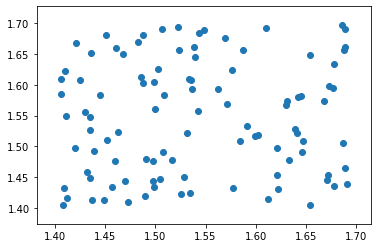

In [17]:
df = pd.DataFrame(savesamples)

print(df)

delta_a = 1e3*(df['a_p_2*'] - df['a_p_1*'])
delta_n = 1e3*(df['n_p_2*'] - df['n_p_1*'])

print(np.max(delta_n))

f_a = interp2d(df.n_1, df.n_2, delta_a)
f_n = interp2d(df.n_1, df.n_2, delta_n)

nx = 50
ny = 50
x = np.linspace(min(df.n_1), max(df.n_1), nx)
y = np.linspace(min(df.n_2), max(df.n_2), ny)

c_a = f_a(x,y)
c_n = f_n(x,y)

print(np.max(c_n))

xx, yy = np.meshgrid(x, y)

plt.scatter(df.n_1, df.n_2)

In [13]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        #I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

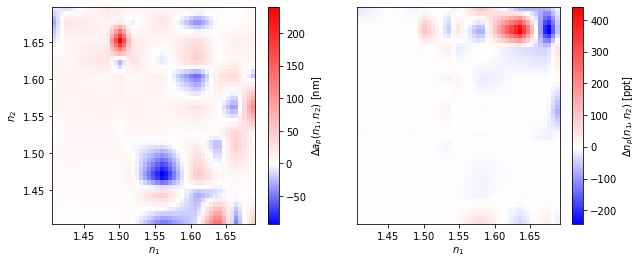

In [14]:
fig = plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
ct1 = ax1.pcolormesh(xx,yy, c_a, cmap='bwr', norm=MidpointNormalize(midpoint=0,vmin=np.min(c_a), vmax=np.max(c_a)))
cb1 = plt.colorbar(ct1)
ax1.set_xlabel(r'$n_1$')
ax1.set_ylabel(r'$n_2$')

ax2 = plt.subplot(122)
ct2 = ax2.pcolormesh(xx,yy,c_n, cmap='bwr', norm=MidpointNormalize(midpoint=0,vmin=np.min(c_n), vmax=np.max(c_n)))
cb2 = plt.colorbar(ct2)
ax2.set_xlabel(r'$n_1$')
ax2.set_yticks([])
cb1.set_label(r'$\Delta a_p(n_1, n_2)$ [nm]')
cb2.set_label(r'$\Delta n_p(n_1, n_2)$ [ppt]')

#fig.savefig('single_double_coating_fitdifference.png')

In [55]:
print((df['a_p_1*'] - df['a_p_2*'])*1e3)


0     -2.433410
1     -3.764047
2     -5.102884
3     -6.436785
4     -7.806479
        ...    
95    -7.424697
96    -8.717884
97    -9.836319
98   -10.795753
99   -11.959863
Length: 100, dtype: float64
